# Final Project Notebook
This is the Notebook presenting the research and work done for our project, for the team OddBits.

### Project Statement
What are the countries most used when pathfinding while playing Wikispeedia? What factors influence the choice of countries to cross? Is this choice well utilized? Does it actually help game outcomes?

### Data Used
Besides the provided Wikispeedia dataset, we've done some cursory research of our own, extracting a country's GDP and population using the World Bank API, documented [here](https://documents.worldbank.org/en/publication/documents-reports/api) and Olympic Medals, taken from [here](https://worldpopulationreview.com/country-rankings/olympic-medals-by-country), as well as the choice of countries by continent taken from [here](https://worldpopulationreview.com/country-rankings/list-of-countries-by-continent) (note that Turkey and the Caucasus were considered as Asian, Russia and Cyprus as European, and the North-South American border was drawn between Panama and Colombia).

### General Workflow
We had been working on finding player improvements up until Wednesday Dec 20th, when we were notified by Prof. Robert West that, in fact, hashedIpAddresses were many-to-many, meaning it was essentially impossible to quantify player improvement with our dataset only (this also explained the strange results found in our data in earlier attempts). Hence, we went for a Plan B, which you can find in the [Project Statement](#project-statement). Without making any excuses, what you're seeing here is the result of a 72-hour mad dash for results, please keep that in mind!

### What We've Achieved
We've been able to quantify how much a player may visit a certain page on the way to their target, and investigated what factors might have influenced their choice of pathfinding, as well as evaluating whether or not that strategy was succesful. We've tried to pinpoint whether or not external biases exist, and whether they ended up *helping* the player's pathfinding, or *penalized* it.

In [107]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry
import requests
import statsmodels.formula.api as smf
from scipy.stats import f_oneway,ttest_ind
from scipy.stats.kde import gaussian_kde 
from urllib.parse import unquote

# Import the data with the correct format
data_folder = '../Data'
paths_folder = data_folder + '/wikispeedia_paths-and-graph'

# Define the columns of each dataframe
columns_f = ['hashedIpAddress','timestamp','durationInSec','path','rating']
columns_u = ['hashedIpAddress','timestamp','durationInSec','path','target', 'type']

# Define the path to each dataframe
finished_paths = paths_folder + '/paths_finished.tsv'
unfinished_paths = paths_folder + '/paths_unfinished.tsv'
distance_matrix_file = paths_folder + "/shortest-path-distance-matrix.txt"
articles_list_file = paths_folder + '/articles.tsv'
added_data_folder = './added_data'

# Load the Data
df_success = pd.read_csv(finished_paths,comment='#',sep='\t',names=columns_f)
df_fail = pd.read_csv(unfinished_paths,comment='#',sep='\t',names=columns_u)

# Control
print('Finished Paths:')
display(df_success)

print('Unfinished Paths:')
display(df_fail)

# Find the median timestamp in df_success
median_timestamp_success = pd.to_datetime(df_success['timestamp'], unit='s').median()
max_timestamp_success = pd.to_datetime(df_success['timestamp'], unit='s').max()

# Find the median timestamp in df_fail
median_timestamp_fail = pd.to_datetime(df_fail['timestamp'], unit='s').median()
max_timestamp_fail = pd.to_datetime(df_fail['timestamp'], unit='s').max()

# Convert the median timestamps to human-readable format
median_timestamp_success_human = median_timestamp_success.strftime('%Y-%m-%d %H:%M:%S')
median_timestamp_fail_human = median_timestamp_fail.strftime('%Y-%m-%d %H:%M:%S')
max_timestamp_success_human = max_timestamp_success.strftime('%Y-%m-%d %H:%M:%S')
max_timestamp_fail_human = max_timestamp_fail.strftime('%Y-%m-%d %H:%M:%S')

# Print the median timestamps in human-readable format
print('Median Timestamp in df_success:', median_timestamp_success_human)
print('Median Timestamp in df_fail:', median_timestamp_fail_human)
print('Max Timestamp in df_success:', max_timestamp_success_human)
print('Max Timestamp in df_fail:', max_timestamp_fail_human)


C:\Users\marck\AppData\Local\Temp\ipykernel_14256\2637580480.py:10: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  from scipy.stats.kde import gaussian_kde


Finished Paths:


,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0
...,...,...,...,...,...
51313,15a13a1d66ef5456,1349231015,66,Yagan;Ancient_Egypt;Civilization,NaN
51314,2ef7ac844cefda58,1300254138,165,Yagan;Folklore;Brothers_Grimm;<;19th_century;C...,3.0
51315,12863abb7887f890,1385095372,228,Yagan;Australia;England;France;United_States;T...,NaN
51316,19f8284371753362,1298792567,56,Yarralumla%2C_Australian_Capital_Territory;Aus...,1.0


Unfinished Paths:


,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout
...,...,...,...,...,...,...
24870,109ed71f571d86e9,1389787605,180,Franz_Kafka;Tuberculosis;World_Health_Organiza...,Cholera,restart
24871,232f992e57d43e8d,1389787697,6,Modern_history,Hollandic,restart
24872,2e09a7224600a7cd,1389798400,1900,Computer_programming;Linguistics;Culture;Popul...,The_Beatles,timeout
24873,60af9e2138051b96,1389799481,1903,Jamaica;United_Kingdom;World_War_II;Battle_of_...,Alan_Turing,timeout


Median Timestamp in df_success: 2010-09-07 21:16:24
Median Timestamp in df_fail: 2012-09-25 15:23:43
Max Timestamp in df_success: 2014-01-15 22:00:50
Max Timestamp in df_fail: 2014-01-15 21:54:01


It seems the median game was played sometime between 2011 and 2012! It might be a good idea to consider data from 2011, as that's what the median player would know while playing, and what would possibly bias their choices.

In [108]:
df_fail = df_fail[~((df_fail.type == 'timeout') &
                    (~df_fail['path'].str.contains(';')))].copy()   
#find() returns -1 if not in str. Not finding a ; means player stayed at start
#Writing the inverse condition with a not is more clear


In [109]:
#Some housekeeping to make everything easy-access 

paths_success = df_success.path.apply(lambda x: x.split(';')).copy()
df_success['target'] = paths_success.apply(lambda x: x[len(x)-1])
df_fail.path = df_fail.path.map(str) + ';' + df_fail.target.map(str)


In [110]:
with open(distance_matrix_file, 'r') as file:
    content = file.read()

# Convert to a 2D list representing the distance matrix
rows = content.strip().split('\n')[17:]
distance_matrix = [[int(dist) if dist != '_' else -1 for dist in row] for row in rows]

# We need to get the list of articles as presented in the data, in order to know their index in the dataset, and hence interpret our distance matrix
articles = pd.read_csv("../data/wikispeedia_paths-and-graph/articles.tsv", sep='\t', skiprows= 11, skip_blank_lines=True)
articles_arr = articles.values
article_list = (item[0] for item in articles_arr)

article_index_map = {article: index for index, article in enumerate(article_list)}

In [111]:
columns_cat = ['article', 'category', 'sub_category', 'sub_sub_category']
df_categories = pd.read_csv(paths_folder + '/categories.tsv', comment='#',sep='\t',names=columns_cat)

def split_categories(row):
    categories = row.category.split('.')[1:]    #Drop the "subject."
    row['category'] = categories[0]
    if len(categories) > 1:
        row['sub_category'] = categories[1]
    if len(categories) > 2:
        row['sub_sub_category'] = categories[2]
    return row

df_categories = df_categories.apply(split_categories, axis=1).copy()

In [112]:
def get_distance(row):
    start_index = int(row.start)
    end_index = int(row.end)
    if start_index is None or end_index is None:
        return -1
    return distance_matrix[start_index][end_index]

def augment(df):
    df_out = df.copy()
    df_out['start'] = df.path.apply(lambda x: article_index_map.get(x.split(';')[0])).copy()
    df_out['end']   = df.path.apply(lambda x: article_index_map.get(x.split(';')[-1])).copy()
    df_out = df_out.dropna(axis=0, subset=['end']).copy()
    df_out['game_len'] = df_out.path.apply(lambda x: len(x.split(';')) - 1).copy()
    df_out['optimal_len'] = df_out.apply(get_distance, axis = 1).copy()
    return df_out


In [113]:
#Let's augment our success Dataframe, with the start and end id, as well as a game_len and optimal_len column
df_success = augment(df_success)
df_fail = augment(df_fail)

display(df_success)
display(df_fail)

,hashedIpAddress,timestamp,durationInSec,path,rating,target,start,end,game_len,optimal_len
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,African_slave_trade,10,143,8,3
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0,African_slave_trade,10,143,4,3
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN,African_slave_trade,10,143,7,3
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN,Greece,10,1793,3,2
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0,John_F._Kennedy,10,2266,6,3
...,...,...,...,...,...,...,...,...,...,...
51313,15a13a1d66ef5456,1349231015,66,Yagan;Ancient_Egypt;Civilization,NaN,Civilization,4558,928,2,2
51314,2ef7ac844cefda58,1300254138,165,Yagan;Folklore;Brothers_Grimm;<;19th_century;C...,3.0,Fiction,4558,1500,8,3
51315,12863abb7887f890,1385095372,228,Yagan;Australia;England;France;United_States;T...,NaN,U.S._Open_%28tennis%29,4558,4273,6,3
51316,19f8284371753362,1298792567,56,Yarralumla%2C_Australian_Capital_Territory;Aus...,1.0,Abraham_Lincoln,4562,97,3,2


,hashedIpAddress,timestamp,durationInSec,path,target,type,start,end,game_len,optimal_len
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great;First_Cru...,First_Crusade,timeout,2616,1516.0,3,3
3,53a53bc244e08a6a,1297094761,49,Paraguay;Mount_St._Helens,Mount_St._Helens,restart,3156,2859.0,1,3
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia;Mount_St._Helens,Mount_St._Helens,timeout,3156,2859.0,2,3
5,131600803df4895e,1297100557,2009,Agriculture;History_of_the_world;China;Yangtze...,Grand_Canal_of_China,timeout,149,1754.0,4,3
6,486bb79910fe9dd2,1297101660,1932,Mind;Christianity;Europe;Renaissance;Ancient_G...,Scouting,timeout,2780,3662.0,7,4
...,...,...,...,...,...,...,...,...,...,...
24870,109ed71f571d86e9,1389787605,180,Franz_Kafka;Tuberculosis;World_Health_Organiza...,Cholera,restart,1585,902.0,8,3
24871,232f992e57d43e8d,1389787697,6,Modern_history;Hollandic,Hollandic,restart,2802,1993.0,1,3
24872,2e09a7224600a7cd,1389798400,1900,Computer_programming;Linguistics;Culture;Popul...,The_Beatles,timeout,1008,4040.0,5,3
24873,60af9e2138051b96,1389799481,1903,Jamaica;United_Kingdom;World_War_II;Battle_of_...,Alan_Turing,timeout,2205,164.0,4,3


Time to get serious with the analysis!

In [114]:
def get_iso_code(row):
    try:
        country_raw = row['Country']
        country_name = country_raw.replace("_", "").lower()
        #Hardcoded exceptions, because pycountry doesn't know them or they cause issues. Note this is not comprehensive, but it's good enough for our purposes
        if(country_name == "swaziland"):
            country_name = "SWZ"

        if(country_name == "turkey"):
            country_name = "TUR"

        if(country_name == "unitedstates"):
            country_name = "USA"

        if(country_name == "unitedkingdom"):
            country_name = "GBR"

        if(country_name == "southkorea" or country_name == "korea"):
            return "KOR"
        
        if(country_name == "southafrica"):
            return "ZAF"
        
        if(country_name == "saudiarabia"):
            return "SAU"
        #More games ended up targeting Dubai or Abu Dhabi, so we'll just group them together under UAE -> ISO code ARE
        if(country_name == "unitedarabemirates" or country_name == "dubai" or country_name == "abudhabi"):
            return "ARE"
        
        if(country_name == "republicofchina"):
            return "TWN"
        
        if(country_name == "czechrepublic"):
            return "CZE"
        
        if(country_name == "hongkong"):
            return "HKG"
        
        if(country_name == "dominicanrepublic"):
            return "DOM"
        
        if(country_name == "northkorea"):
            return "PRK"
        
        country = pycountry.countries.search_fuzzy(country_name)[0]
        return country.alpha_3
    except LookupError:
        return None



In [115]:
# Merge the two dataframes, with a success column allowing us to evaluate average success rate by simple averaging
df_combined = pd.concat([df_success.assign(success=1), df_fail.assign(success=0)])

# Merge df_categories with the target article
merged_df = pd.merge(df_combined, df_categories, left_on='target', right_on='article')
countries_data = merged_df[merged_df['category'] == 'Countries']['target']

country_counts = countries_data.value_counts()

average_success_rate = merged_df[merged_df['category'] == 'Countries'].groupby('target')['success'].mean()

# Create a dataframe with the country counts and average success rate
df_countries = pd.DataFrame({'Country': country_counts.index, 'Count': country_counts.values, 'Average Success Rate': average_success_rate.values})

df_countries['Average Excess Path Length'] = df_success['game_len'] - df_success['optimal_len']

df_countries['ISO'] = df_countries.apply(get_iso_code, axis=1)



df_countries = df_countries.groupby('ISO').agg(
            {'Country': lambda x: x.loc[x.idxmin()].lower(), #Keep the first country name, as we are sorted by count at this point, this works almost always
            'Count': 'sum', 
            'Average Success Rate': lambda x: np.average(x, weights=df_countries.loc[x.index, 'Count']), 
            'Average Excess Path Length': lambda x: np.average(x, weights=df_countries.loc[x.index, 'Count'])}).reset_index()

# Here is where the first line of the groupby fails, so we need to manually fix it
df_countries.loc[df_countries['Country'] == 'abu_dhabi', 'Country'] = 'united_arab_emirates'
df_countries.loc[df_countries['Country'] == 'abkhazia', 'Country'] = 'georgia'


df_countries = df_countries.dropna(axis=0, subset=['ISO']).copy()

display(df_countries)

SubdivisionHierarchy(code='MX-MEX', country_code='MX', name='México', parent_code=None, type='State')
SubdivisionHierarchy(code='NG-NI', country_code='NG', name='Niger', parent_code=None, type='State')
SubdivisionHierarchy(code='PA-8', country_code='PA', name='Panamá', parent_code=None, type='Province')
SubdivisionHierarchy(code='DJ-DJ', country_code='DJ', name='Djibouti', parent_code=None, type='City')
SubdivisionHierarchy(code='BZ-BZ', country_code='BZ', name='Belize', parent_code=None, type='District')
SubdivisionHierarchy(code='GT-GU', country_code='GT', name='Guatemala', parent_code=None, type='Department')
SubdivisionHierarchy(code='GN-ML', country_code='GN', name='Mali', parent='L', parent_code='GN-L', type='Prefecture')
SubdivisionHierarchy(code='NL-AW', country_code='NL', name='Aruba', parent_code=None, type='Country')
SubdivisionHierarchy(code='BE-WLX', country_code='BE', name='Luxembourg', parent='WAL', parent_code='BE-WAL', type='Province')
SubdivisionHierarchy(code='LU-LU'

,ISO,Country,Count,Average Success Rate,Average Excess Path Length
0,ABW,aruba,11,0.384615,0.0
1,AFG,afghanistan,48,0.900000,9.0
2,AGO,angola,11,0.909091,3.0
3,AIA,anguilla,9,0.954545,3.0
4,ALB,albania,8,0.857143,4.0
...,...,...,...,...,...
160,WSM,samoa,13,0.937500,4.0
161,YEM,yemen,16,0.950000,1.0
162,ZAF,south_africa,38,0.800000,4.0
163,ZMB,zambia,18,0.935484,10.0


In [116]:
# Define the base URL for the World Bank API
base_url = "http://api.worldbank.org/v2"
year = "2011"                                   # year of interest
indicators = ["NY.GDP.MKTP.CD", "SP.POP.TOTL"]  # GDP (current US$) and total population

def get_pop_data(row):
    country = row['ISO']
    # Send a GET request to the World Bank API
    response = requests.get(f"{base_url}/country/{country}/indicator/SP.POP.TOTL?date={year}&format=json")
    data = response.json()
    try:
        return data[1][0]['value']
    except:
        return None
    
def get_gdp_data(row):
    country = row['ISO']
    # Send a GET request to the World Bank API
    response = requests.get(f"{base_url}/country/{country}/indicator/NY.GDP.MKTP.CD?date={year}&format=json")
    data = response.json()
    try:
        return data[1][0]['value']
    except:
        return None

The below cell should only be run once, it queries the API and saves the results to a file. Keep it commented, unless data needs to be updated. 

Otherwise, just run the file with the last line uncommented!

This cell is kept here simply to clarify *how* that data was generated.

In [117]:
# df_countries['Population'] = df_countries.apply(get_pop_data, axis=1)
# df_countries['GDP'] = df_countries.apply(get_gdp_data, axis=1)

# df_data = df_countries.sort_values(by=['Count'], ascending=False).copy()

# display(df_data)
# # Normalize population
# mean_population = df_data['Population'].mean()
# sigma_population = df_data['Population'].std()
# df_data['Normalized Population'] = (df_data['Population'] - mean_population) / sigma_population

# # Normalize GDP
# mean_gdp = df_countries['GDP'].mean()
# sigma_gdp = df_countries['GDP'].std()
# df_data['Normalized GDP'] = (df_data['GDP'] - mean_gdp) / sigma_gdp

# df_data['GDP per capita'] = df_data['GDP'] / df_countries['Population']
# # Add continent information

# added_data_folder = '../added_data'

# df_continents = pd.read_csv(added_data_folder + '/list-of-countries-by-continent-2023.csv', sep=',')

# df_data_cont = pd.merge(df_data, df_continents[['cca3', 'region']], left_on='ISO', right_on='cca3', how='left')
# df_data_cont = df_data_cont.drop(columns=['cca3'])

# df_data_cont = df_data_cont.rename(columns={'region': 'Continent'})
# display(df_data_cont)
# def count_countries_in_paths(countries, paths, success):    
    
#     country_counts = {country: 0 for country in countries}

#     for path in paths:
#         path = path.lower().replace(" ", "_")
#         for country in countries:
#             country = country.lower()
#             country = country.replace(" ", "_")
#             if country in path.split(';'):
#                 country_counts[country] += 1

#     counts_df = pd.DataFrame(list(country_counts.items()), columns=['Country', 'Count_in_paths'])
#     counts_df['Success_when_used'] = success
    
#     return counts_df

# countries = df_data_cont['Country'].tolist()
# # Extract the paths from the initial dataframes, distinguishing successes and failures
# paths_s = df_success['path'].tolist()
# paths_f = df_fail['path'].tolist()
# result_s = count_countries_in_paths(countries, paths_s, success=1)
# result_f = count_countries_in_paths(countries, paths_f, success=0)

# paths_merge = pd.merge(result_s, result_f, on='Country', how='outer', suffixes=('_s', '_f'))
# paths_merge['Count_in_paths'] = paths_merge['Count_in_paths_s'] + paths_merge['Count_in_paths_f']

# paths_merge['Success_when_used'] = (paths_merge['Success_when_used_s'] * paths_merge['Count_in_paths_s'])/ paths_merge['Count_in_paths']
# paths_merge = paths_merge.drop(columns=['Count_in_paths_s', 'Count_in_paths_f', 'Success_when_used_s', 'Success_when_used_f'])


# paths_merge['ISO'] = paths_merge.apply(get_iso_code, axis=1)

# df_paths = pd.merge(df_data_cont, paths_merge, on='ISO', how='left').drop(columns=['Country_y']).rename(columns={'Country_x': 'Country'}).copy()
# df_paths.loc[df_paths['Country'] == 'abkhazia', 'Country'] = 'georgia'

# display(df_paths)

# df_paths.to_csv('../generated_data/df_paths.csv', index=False)

df_paths = pd.read_csv('../generated_data/df_paths.csv')
display(df_paths)

,ISO,Country,Count,Average Success Rate,Average Excess Path Length,Population,GDP,Normalized Population,Normalized GDP,GDP per capita,Continent,Count_in_paths,Success_when_used
0,ARE,united_arab_emirates,126,0.861949,2.301587,8.575205e+06,3.608327e+11,-0.225124,-0.061075,42078.613813,Asia,195,0.835897
1,CHN,china,118,1.000000,5.000000,1.345035e+09,7.551546e+12,8.769585,4.632503,5614.386022,Asia,1437,0.772443
2,VNM,vietnam,109,0.916667,1.000000,8.834912e+07,1.725950e+11,0.311774,-0.183943,1953.557150,Asia,236,0.805085
3,JPN,japan,91,0.937500,4.000000,1.278330e+08,6.233147e+12,0.577511,3.771947,48760.078949,Asia,1386,0.772006
4,RUS,russia,88,1.000000,1.000000,1.429609e+08,2.045923e+12,0.679325,1.038830,14311.064346,Europe,1319,0.763457
...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,GEO,georgia,6,0.923077,2.000000,3.756441e+06,1.510749e+10,-0.257556,-0.286740,4021.755230,Asia,20,0.700000
161,HND,honduras,6,0.800000,2.000000,8.622504e+06,1.771028e+10,-0.224806,-0.285041,2053.959695,North America,42,0.761905
162,MRT,mauritania,6,0.888889,0.000000,3.524249e+06,6.764628e+09,-0.259118,-0.292186,1919.452271,Africa,37,0.756757
163,GUM,guam,6,0.965517,1.000000,1.656490e+05,4.984000e+09,-0.281722,-0.293348,30087.715591,Oceania,43,0.674419


### Here, we have now written all the data taken from *reputable sources* to a CSV, to avoid sending queries again.

### Now let's actually take a look to see if countries often used in a path yield good success rates!

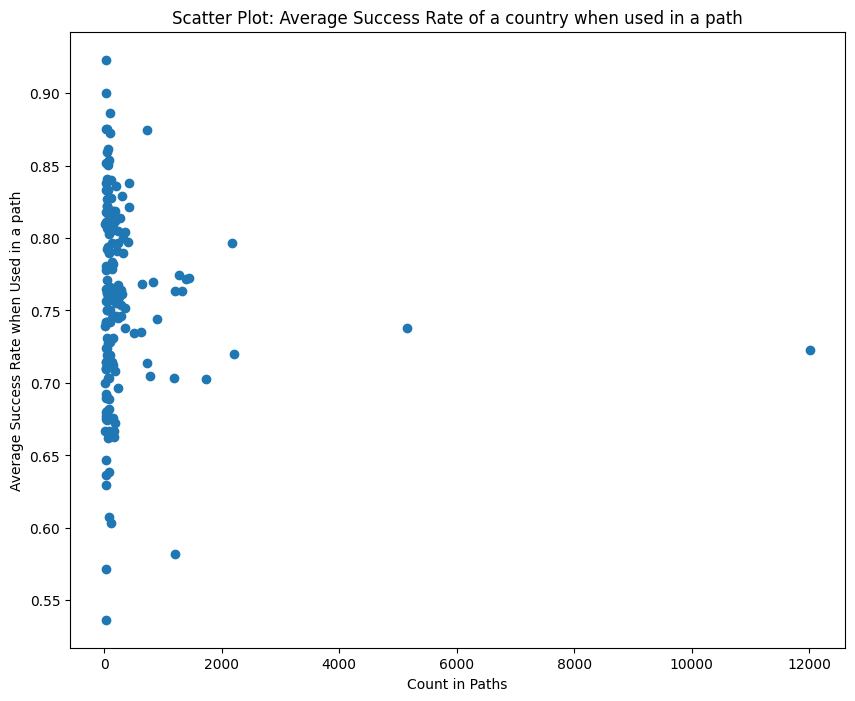

In [118]:
# Graph 1: Avg success rate when used on y, Counts in path x
plt.figure(figsize=(10, 8))
plt.scatter(df_paths['Count_in_paths'], df_paths['Success_when_used'])
plt.xlabel('Count in Paths')
plt.ylabel('Average Success Rate when Used in a path')
plt.title('Scatter Plot: Average Success Rate of a country when used in a path')
#plt.xscale('log')
plt.show()


...*what?*

Let's try that again, taking out those two countries used so often, so we can focus in on all the other countries!

['united_states', 'united_kingdom']


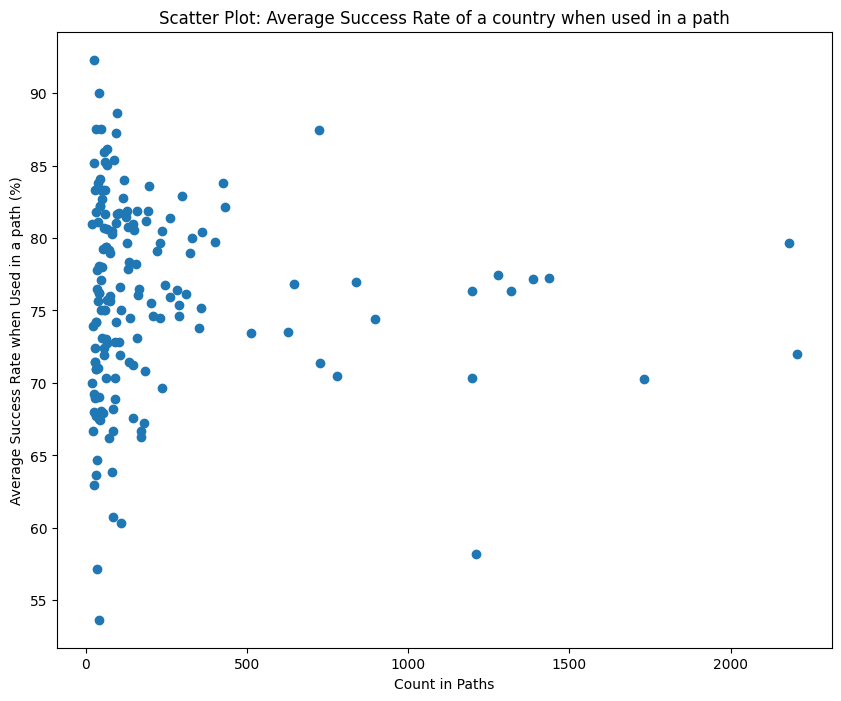

In [119]:
outliers_list = df_paths[df_paths['Count_in_paths'] > 4000].Country.tolist()
print(outliers_list)

df_plot = df_paths[df_paths['Count_in_paths'] < 4000]

plt.figure(figsize=(10, 8))
plt.scatter(df_plot['Count_in_paths'], 100*df_plot['Success_when_used'])
plt.xlabel('Count in Paths')
plt.ylabel('Average Success Rate when Used in a path (%)')
plt.title('Scatter Plot: Average Success Rate of a country when used in a path')
#plt.xscale('log')
plt.show()

Notice the Outliers are the US and the UK, we'll investigate in due time whether it makes sense for players to employ these articles that often!

What about a logarithm? Don't those always work?

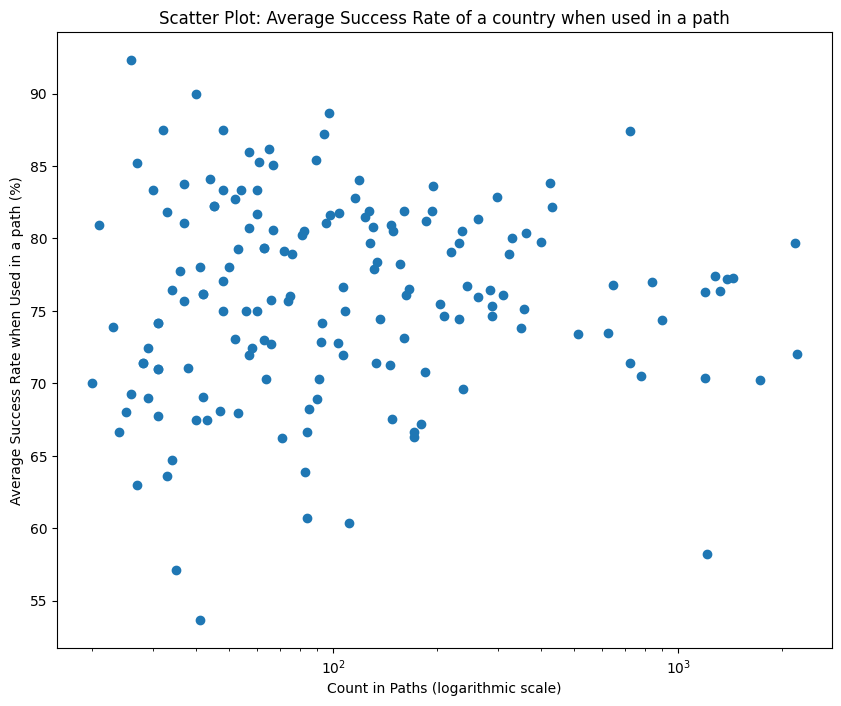

In [120]:
plt.figure(figsize=(10, 8))
plt.scatter(df_plot['Count_in_paths'], 100*df_plot['Success_when_used'])
plt.xlabel('Count in Paths (logarithmic scale)')
plt.ylabel('Average Success Rate when Used in a path (%)')
plt.title('Scatter Plot: Average Success Rate of a country when used in a path')
plt.xscale('log')
plt.show()

Wow! It really seems like there's no relation at all here!

Now let's actually look at the linear regression:

In [121]:
model1 = smf.ols(formula='Success_when_used ~ Count_in_paths', data=df_plot)
model1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Success_when_used   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.3180
Date:                Fri, 22 Dec 2023   Prob (F-statistic):              0.574
Time:                        17:26:03   Log-Likelihood:                 209.05
No. Observations:                 163   AIC:                            -414.1
Df Residuals:                     161   BIC:                            -407.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.7612      0.006    123.331      0.000       0.749       0.773
Count_in_paths -7.899e-06    1.4e-05     -0.564      0.574   -3.56e-05    1.98e-05
==============================================================================
Omnibus:                        6.497   Durbin-Watson:                   2.177
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                6.123
Skew:                          -0.451   Prob(JB):                       0.0468
Kurtosis:                       3.298   Cond. No.                         514.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

With a downright *huge* p-score of 0.57, it seems that the choice of an article to cross when pathfinding is *unrelated* to the actual result of pathfinding: a player's choice of a country does not affect their success outcome!

This downright begs the question: what is it that's actually *motivating* the country choice? Let's measure to how many articles each country is linked, and how *central* to the graph it actually is.

In [122]:
distances = []
neighbors = []
for row in distance_matrix:
    row_values = []
    neighbors_count = 0
    for i in range(len(row)):
        if row[i] != -1:
            row_values.append(row[i])
        else:
            row_values.append(None)
        if row[i] == 1:
            neighbors_count+=1
    distances.append(row_values)
    neighbors.append(neighbors_count)

distances_array = np.array(distances)
neighbors_array = np.array(neighbors)

In [123]:
# We compute here the closeness centrality of each article 
# Since the numbers are very small, we multiply by 100000 to get more readable numbers

from urllib.parse import unquote

num_articles = len(distances_array)
centrality = []
for i in range(num_articles):
    Farness = sum(distances_array[i, j] for j in range(num_articles) if j != i and distances_array[i, j] is not None)
    closeness_centrality = 100000 / Farness if Farness != 0 else 0
    centrality.append(closeness_centrality)


In [124]:
with open(articles_list_file, 'r') as articles_file:
    articles_lines = articles_file.readlines()

# Extract article names from the articles.tsv file
article_names = [unquote(line.strip()) for line in articles_lines if not line.startswith('#') and line.strip() != 'articles']

df_centrality = pd.DataFrame({'Article': article_names, 'Closeness Centrality': centrality, 'Number of Connexions': neighbors_array})

display(df_centrality.sort_values(by=['Closeness Centrality'], ascending=False))

,Article,Closeness Centrality,Number of Connexions
1600,Friend_Directdebit,100000.000000,1
3849,Sponsorship_Directdebit,50000.000000,2
4297,United_States,9.924573,294
39,21st_century,9.620010,155
1989,History_of_the_world,9.562972,147
...,...,...,...
2351,Klinefelter's_syndrome,0.000000,0
3928,Suikinkutsu,0.000000,0
1257,Duchenne_muscular_dystrophy,0.000000,0
3108,Osteomalacia,0.000000,0


**Please note that, for readability, we have multiplied Closeness Centrality scores by 100'000**

So it looks like we have weird (meta-)articles, with a very high success rate. Let's get them out of here, and look at the data itself.

In [125]:
df_centrality = df_centrality[(df_centrality.Article != "Friend_Directdebit") & (df_centrality.Article != "Sponsorship_Directdebit")]
df_centrality = df_centrality.sort_values(by=['Closeness Centrality'], ascending=False)
display(df_centrality)

,Article,Closeness Centrality,Number of Connexions
4297,United_States,9.924573,294
39,21st_century,9.620010,155
1989,History_of_the_world,9.562972,147
331,Argentina,9.534706,163
24,19th_century,9.499383,167
...,...,...,...
1257,Duchenne_muscular_dystrophy,0.000000,0
2530,Local_community,0.000000,0
3928,Suikinkutsu,0.000000,0
3645,Schatzki_ring,0.000000,0


Oh Wow! We have two countries at the *very* top of the Closeness Centrality list: the United States and Argentina

What about #Connexions ?

In [126]:
df_centrality = df_centrality.sort_values(by=['Number of Connexions'], ascending=False)
display(df_centrality)
# A bit of housekeeping to prep for merging
df_centrality.Article = df_centrality.Article.apply(str.lower)
df_centrality.loc[df_centrality['Article'] == 'georgia_(country)', 'Article'] = 'georgia'

,Article,Closeness Centrality,Number of Connexions
4297,United_States,9.924573,294
1247,Driving_on_the_left_or_right,9.448224,255
2504,List_of_countries,9.254975,244
2503,List_of_circulating_currencies,9.262690,236
2515,List_of_sovereign_states,9.178522,216
...,...,...,...
4333,Vacutainer,0.000000,0
4289,Underground_(stories),0.000000,0
3352,Private_Peaceful,0.000000,0
3108,Osteomalacia,0.000000,0


The US is still there! It would seem it was a worthwhile article to be an outlier!

Now let's merge this data with our previous dataframe! Sorting here by Closeness Centrality:

Let's quickly look whether countries are more central, or have more connexions than your average article!

In [127]:
countries_df_centrality = df_centrality[df_centrality['Article'].apply(str.lower).isin(df_paths.Country)].copy()

print(f"Average Closeness Centrality of countries: {countries_df_centrality['Closeness Centrality'].mean()}, vs. Average Closeness Centrality of all articles: {df_centrality['Closeness Centrality'].mean()}")

t_test, p_val = ttest_ind(countries_df_centrality['Closeness Centrality'], df_centrality['Closeness Centrality'])

print(f"p-value: {p_val}, t-test: {t_test}")

print(f"Average Number of Connexions of countries: {countries_df_centrality['Number of Connexions'].mean()}, vs. Average Number of Connexions of all articles: {df_centrality['Number of Connexions'].mean()}")
t_test, p_val = ttest_ind(countries_df_centrality['Number of Connexions'], df_centrality['Number of Connexions'])

print(f"p-value: {p_val}, t-test: {t_test}")



Average Closeness Centrality of countries: 8.498322681540555, vs. Average Closeness Centrality of all articles: 7.718975072619843
p-value: 1.4237316196309894e-39, t-test: 13.284770774830362
Average Number of Connexions of countries: 67.33333333333333, vs. Average Number of Connexions of all articles: 26.02542372881356
p-value: 4.263442992190478e-90, t-test: 20.563787635986706


Countries are significantly *more* in the Wikispeedia graph than regular articles, and are much more connected! This means we **must** expect user to fall onto them, even should they not want to. This does not mean that users fall into them by chance, they might also be choosing them consciously!

In [128]:
df_comp = pd.merge(df_paths, df_centrality, left_on='Country', right_on='Article', how='left').sort_values(by=['Closeness Centrality'], ascending=False)

display(df_comp.head(10))


,ISO,Country,Count,Average Success Rate,Average Excess Path Length,Population,GDP,Normalized Population,Normalized GDP,GDP per capita,Continent,Count_in_paths,Success_when_used,Article,Closeness Centrality,Number of Connexions
47,USA,united_states,29,0.947368,1.0,311583481.0,1.559973e+13,1.814198,9.885775,50065.966504,North America,12007,0.722495,united_states,9.924573,294
36,ARG,argentina,31,0.857143,13.0,41261490.0,5.301581e+11,-0.005137,0.049448,12848.739151,South America,263,0.813688,argentina,9.534706,163
51,GBR,united_kingdom,28,0.947368,1.0,63258810.0,2.663806e+12,0.142910,1.442139,42109.641880,Europe,5160,0.737791,united_kingdom,9.462528,168
9,DEU,germany,55,0.555556,2.0,80274983.0,3.749315e+12,0.257433,2.150681,46705.895796,Europe,2182,0.796517,germany,9.387908,169
91,LBN,lebanon,17,0.885714,5.0,5045056.0,3.992713e+10,-0.248883,-0.270539,7914.109568,Asia,93,0.741935,lebanon,9.322271,192
40,ISR,israel,30,0.416667,3.0,7765800.0,2.667919e+11,-0.230572,-0.122459,34354.716118,Asia,362,0.803867,israel,9.308387,169
141,ARM,armenia,10,1.000000,2.0,2928976.0,1.014211e+10,-0.263125,-0.289981,3462.681778,Asia,40,0.675000,armenia,9.295408,186
81,BGR,bulgaria,19,0.636364,4.0,7348328.0,5.773704e+10,-0.233381,-0.258914,7857.167070,Europe,82,0.804878,bulgaria,9.249838,145
160,GEO,georgia,6,0.923077,2.0,3756441.0,1.510749e+10,-0.257556,-0.286740,4021.755230,Asia,20,0.700000,georgia,9.208951,180
54,IRN,iran,26,0.666667,2.0,76342971.0,6.261331e+11,0.230970,0.112093,8201.581678,Asia,330,0.800000,iran,9.180207,108


And now by Number of Connexions!

In [129]:
display(df_comp.sort_values(by=['Number of Connexions'], ascending=False).head(10))

,ISO,Country,Count,Average Success Rate,Average Excess Path Length,Population,GDP,Normalized Population,Normalized GDP,GDP per capita,Continent,Count_in_paths,Success_when_used,Article,Closeness Centrality,Number of Connexions
47,USA,united_states,29,0.947368,1.0,311583481.0,1.559973e+13,1.814198,9.885775,50065.966504,North America,12007,0.722495,united_states,9.924573,294
91,LBN,lebanon,17,0.885714,5.0,5045056.0,3.992713e+10,-0.248883,-0.270539,7914.109568,Asia,93,0.741935,lebanon,9.322271,192
141,ARM,armenia,10,1.000000,2.0,2928976.0,1.014211e+10,-0.263125,-0.289981,3462.681778,Asia,40,0.675000,armenia,9.295408,186
160,GEO,georgia,6,0.923077,2.0,3756441.0,1.510749e+10,-0.257556,-0.286740,4021.755230,Asia,20,0.700000,georgia,9.208951,180
65,TUR,turkey,22,0.625000,3.0,74223629.0,8.387853e+11,0.216706,0.250897,11300.785222,Asia,288,0.746528,turkey,9.104980,172
9,DEU,germany,55,0.555556,2.0,80274983.0,3.749315e+12,0.257433,2.150681,46705.895796,Europe,2182,0.796517,germany,9.387908,169
40,ISR,israel,30,0.416667,3.0,7765800.0,2.667919e+11,-0.230572,-0.122459,34354.716118,Asia,362,0.803867,israel,9.308387,169
51,GBR,united_kingdom,28,0.947368,1.0,63258810.0,2.663806e+12,0.142910,1.442139,42109.641880,Europe,5160,0.737791,united_kingdom,9.462528,168
36,ARG,argentina,31,0.857143,13.0,41261490.0,5.301581e+11,-0.005137,0.049448,12848.739151,South America,263,0.813688,argentina,9.534706,163
146,MOZ,mozambique,10,0.615385,0.0,23760421.0,1.461928e+10,-0.122924,-0.287059,615.278660,Africa,75,0.760000,mozambique,8.873902,162


Notice here Lebanon! It is only included in 93 paths, but is a top 5 in both Number of Connexions and Closeness Centrality, this seems to be a blindspot in pathfinding. Argentina too, and both of these are not that likely to be used in a path, when compared to the US or the UK. It would also seem that players reaching those countries are getting "lost", with Argentina crossing incurring a whopping 13 Average Excess Path Length (perhaps, even with its high number of links to articles, it's missing a couple links it *should* have, which would confuse players and throw them into a long chain of research...)

Now for actual data viz and maybe some regressions:

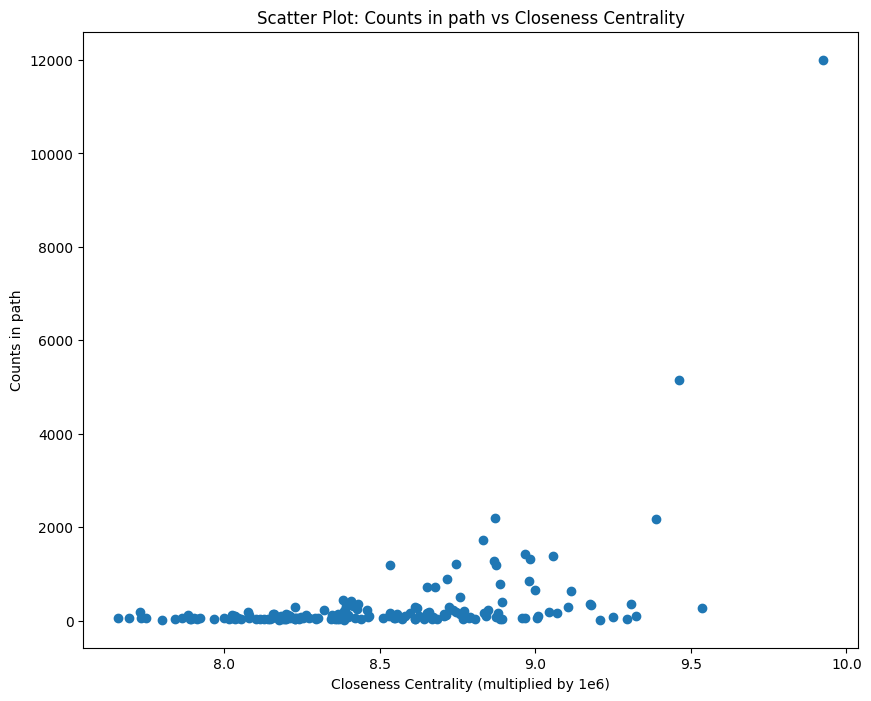

In [130]:
plt.figure(figsize=(10, 8))
plt.scatter(df_comp['Closeness Centrality'], df_comp['Count_in_paths'])
plt.xlabel('Closeness Centrality (multiplied by 1e6)')
plt.ylabel('Counts in path')
plt.title('Scatter Plot: Counts in path vs Closeness Centrality')
#plt.xscale('log')
plt.show()

We might be onto something here! Let's put on a logarithm on the y-axis and see something:

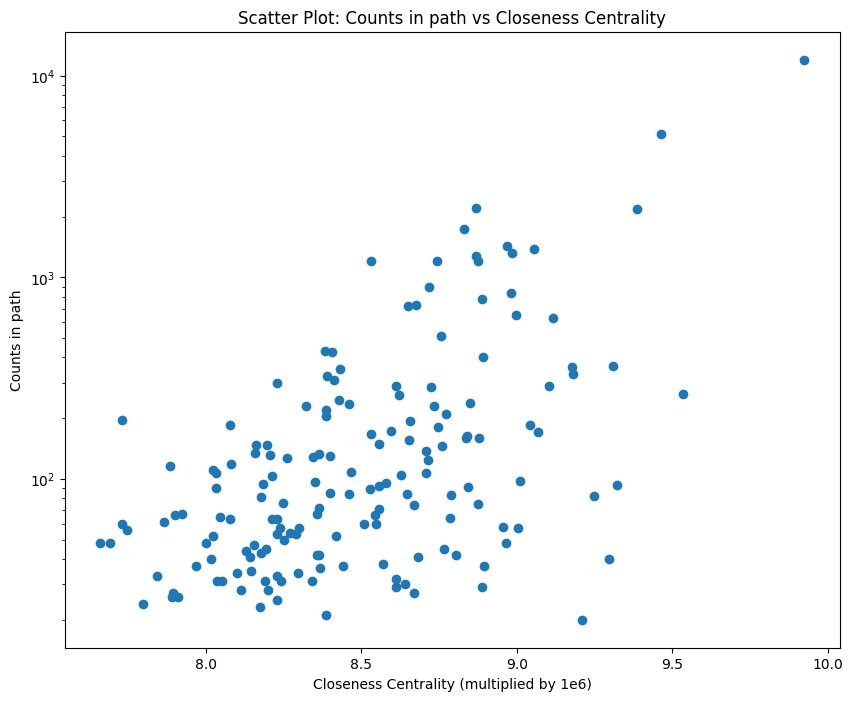

In [131]:
plt.figure(figsize=(10, 8))
plt.scatter(df_comp['Closeness Centrality'], df_comp['Count_in_paths'])
plt.xlabel('Closeness Centrality (multiplied by 1e6)')
plt.ylabel('Counts in path')
plt.title('Scatter Plot: Counts in path vs Closeness Centrality')
plt.yscale('log')
plt.show()

We might have something here! Let's do a linear regression on this log transformed data, to be interpreted as multiplicatives!

C:\Users\marck\AppData\Local\Temp\ipykernel_14256\2435857887.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = model2.fit().params[0]
C:\Users\marck\AppData\Local\Temp\ipykernel_14256\2435857887.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  set_slope = model2.fit().params[1]


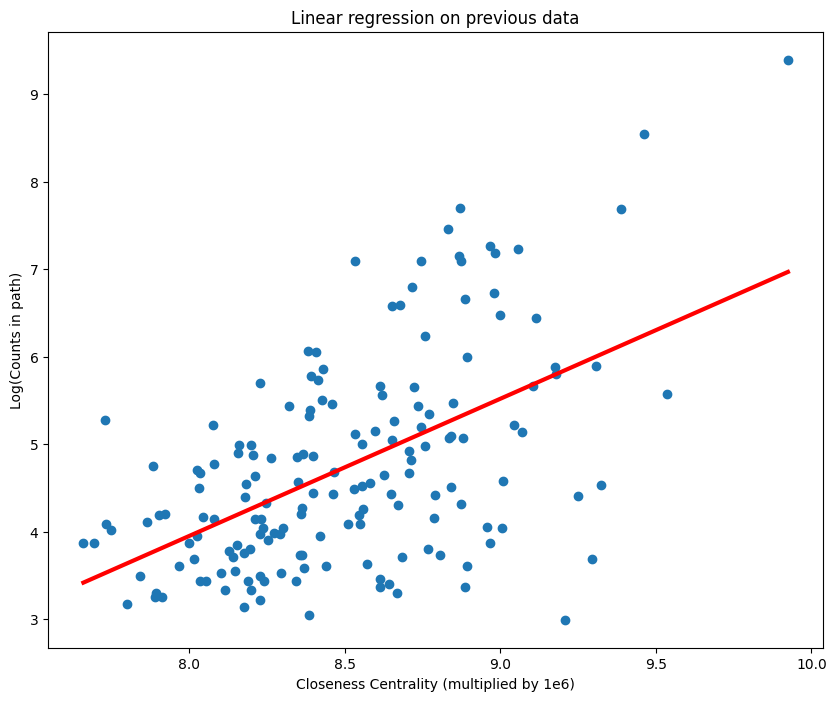

In [132]:
df_regression = df_comp.copy()

df_regression['Counts_in_path_log'] = np.log(df_regression['Count_in_paths'])
df_regression['Closeness_Centrality'] = df_regression['Closeness Centrality']

model2 = smf.ols(formula='Counts_in_path_log ~ Closeness_Centrality', data=df_regression)
model2.fit().summary()
intercept = model2.fit().params[0]
set_slope = model2.fit().params[1]

plt.figure(figsize=(10, 8))
plt.scatter(df_regression['Closeness_Centrality'], df_regression['Counts_in_path_log'])
plt.plot(df_regression['Closeness Centrality'], intercept + set_slope*df_regression['Closeness_Centrality'], color='red', linewidth=3)
plt.xlabel('Closeness Centrality (multiplied by 1e6)')
plt.ylabel('Log(Counts in path)')
plt.title('Linear regression on previous data')
plt.show()

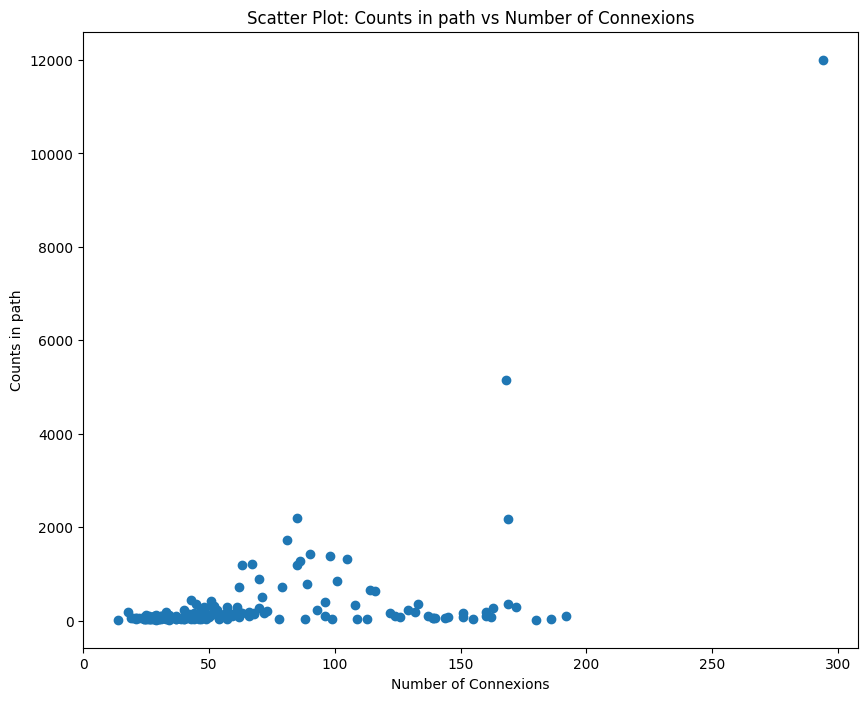

In [133]:
plt.figure(figsize=(10, 8))
plt.scatter(df_comp['Number of Connexions'], df_comp['Count_in_paths'])
plt.xlabel('Number of Connexions')
plt.ylabel('Counts in path')
plt.title('Scatter Plot: Counts in path vs Number of Connexions')
#plt.xscale('log')
plt.show()

Looks weaker... Let's take out the USA outlier, and apply a logarithm on the y axis!

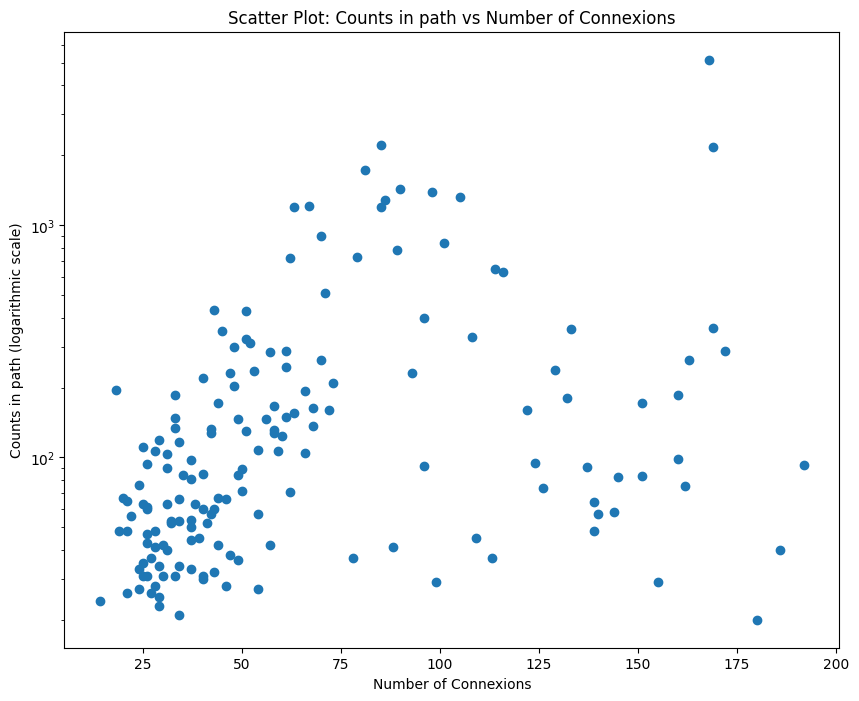

In [134]:
df_plot2 = df_comp[df_comp['Number of Connexions'] < 250].copy()

plt.figure(figsize=(10, 8))
plt.scatter(df_plot2['Number of Connexions'], df_plot2['Count_in_paths'])
plt.xlabel('Number of Connexions')
plt.ylabel('Counts in path (logarithmic scale)')
plt.title('Scatter Plot: Counts in path vs Number of Connexions')
plt.yscale('log')
plt.show()

Does not look promising! Let's still try a regression and see what happens...

In [135]:
df_regression2 = df_plot2.copy()

df_regression2['Number_of_Connexions'] =df_regression2['Number of Connexions']
df_regression2['Counts_in_path_log'] = np.log(df_regression2['Count_in_paths'])

model3 = smf.ols(formula='Counts_in_path_log ~ Number_of_Connexions', data=df_regression2)
model3.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Counts_in_path_log   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     21.76
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           6.44e-06
Time:                        17:26:18   Log-Likelihood:                -243.81
No. Observations:                 164   AIC:                             491.6
Df Residuals:                     162   BIC:                             497.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                4.1175      0.151     27.184      0.000       3.818       4.417
Number_of_Connexions     0.0089      0.002      4.664      0.000       0.005       0.013
==============================================================================
Omnibus:                        9.468   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                9.772
Skew:                           0.596   Prob(JB):                      0.00755
Kurtosis:                       3.093   Cond. No.                         143.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

C:\Users\marck\AppData\Local\Temp\ipykernel_14256\658092310.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = model3.fit().params[0]
C:\Users\marck\AppData\Local\Temp\ipykernel_14256\658092310.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  set_slope = model3.fit().params[1]


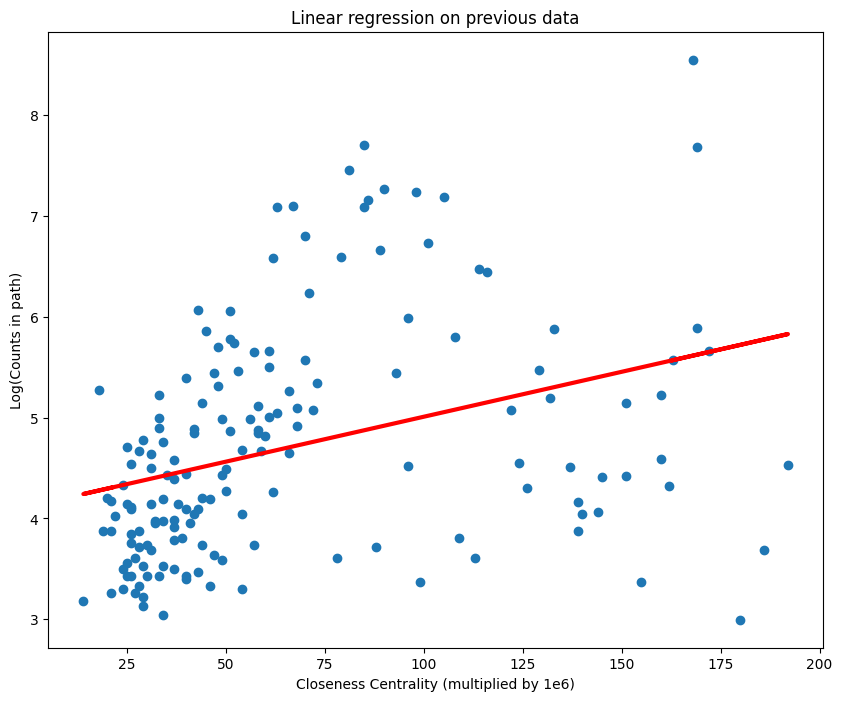

In [136]:
intercept = model3.fit().params[0]
set_slope = model3.fit().params[1]

plt.figure(figsize=(10, 8))
plt.scatter(df_regression2['Number_of_Connexions'], df_regression2['Counts_in_path_log'])
plt.plot(df_regression2['Number_of_Connexions'], intercept + set_slope*df_regression2['Number_of_Connexions'], color='red', linewidth=3)
plt.xlabel('Closeness Centrality (multiplied by 1e6)')
plt.ylabel('Log(Counts in path)')
plt.title('Linear regression on previous data')
plt.show()

That's certainly something!

Something to note is that fitting a linear curve onto a log as we've done here tends to disproportionnately favor smaller weights when fitting. When working on Excel or other tools, this is mitigated by weighting the points when making an exponential fit as we do here. On our website we've included the fits as generated by Excel (re-weighted): this produces an R-square of 0.5 !

Note here than even though the coefficients are small, they are multiplicative!

What we've done essentially is:
$$\log{y} = b_0 + b_1 X \iff y = e^{b_0}e^{b_1 X} = B_0 e^{b_1 X}$$

This means that every increase of 1 (100000 actually) in Closeness Centrality is associated with a .8% increase in usage in paths, which *will* add up over 200...

Important to mention here that players do not *know* these factors while playing. They might be able to guess intuitively which articles have many neighbors, and which might be central, such as the USA, but they might not immediately think of Lebanon or Argentina!

What about the interaction between population and Closeness Centrality?

                            OLS Regression Results                            
Dep. Variable:     Counts_in_path_log   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     21.55
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           8.90e-12
Time:                        17:26:18   Log-Likelihood:                -226.31
No. Observations:                 164   AIC:                             460.6
Df Residuals:                     160   BIC:                             473.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

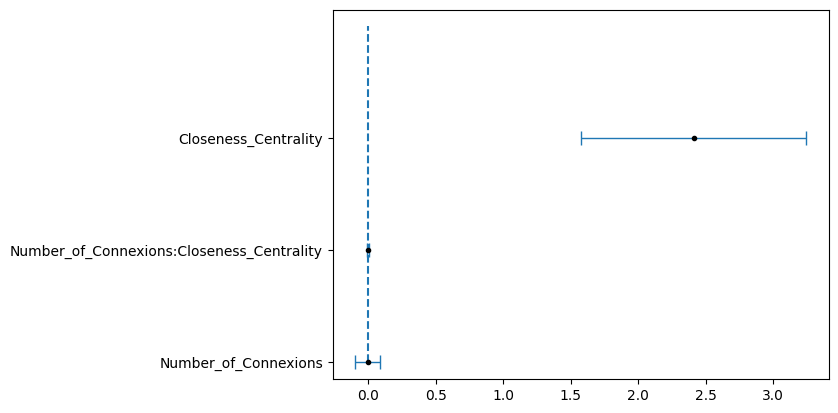

In [137]:
df_interaction = df_plot2.copy()

df_interaction['Number_of_Connexions'] =df_interaction['Number of Connexions']
df_interaction['Counts_in_path_log'] = np.log(df_interaction['Count_in_paths'])
df_interaction['Closeness_Centrality'] = df_interaction['Closeness Centrality']


model_interaction = smf.ols(formula='Counts_in_path_log ~ Number_of_Connexions + Closeness_Centrality + Number_of_Connexions * Closeness_Centrality', data=df_interaction).fit()
summary=model_interaction.summary()
print(summary)

variables = model_interaction.params.index

coeffs = model_interaction.params.values
p_values = model_interaction.pvalues.values
standard_errors = model_interaction.bse.values

conf_ints = model_interaction.conf_int()

print(conf_ints)

l1, l2, l3, l4 = zip(*sorted(zip(coeffs[1:], variables[1:], standard_errors[1:], p_values[1:])))

plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

plt.vlines(0,0, len(l1), linestyle = '--')

plt.yticks(range(len(l2)),l2)
plt.show()

By accounting for closeness centrality *as well as* the number of connexions, we see that the actual factor influencing the choice of a country article is the Closeness Centrality. This makes sense: players would have a more intuitive feel for the centrality of an article than its actual number of connections, even though the number of connections might be more important to *winning* the game itself! Players, it would seem, only choose better connected articles *because* they are more central, not because they are able to assess the best connected articles!

### What is actually motivating player's choices of countries?

Let's try to see what might still be missing for players to actually get a *winning* path! What's causing this Lebano-Argentinan-sized gap? Perhaps there's a geographic bias? Let's plot the Closeness Centralities and Number of Neighbors, while also showing continent!

<Figure size 1500x1000 with 0 Axes>

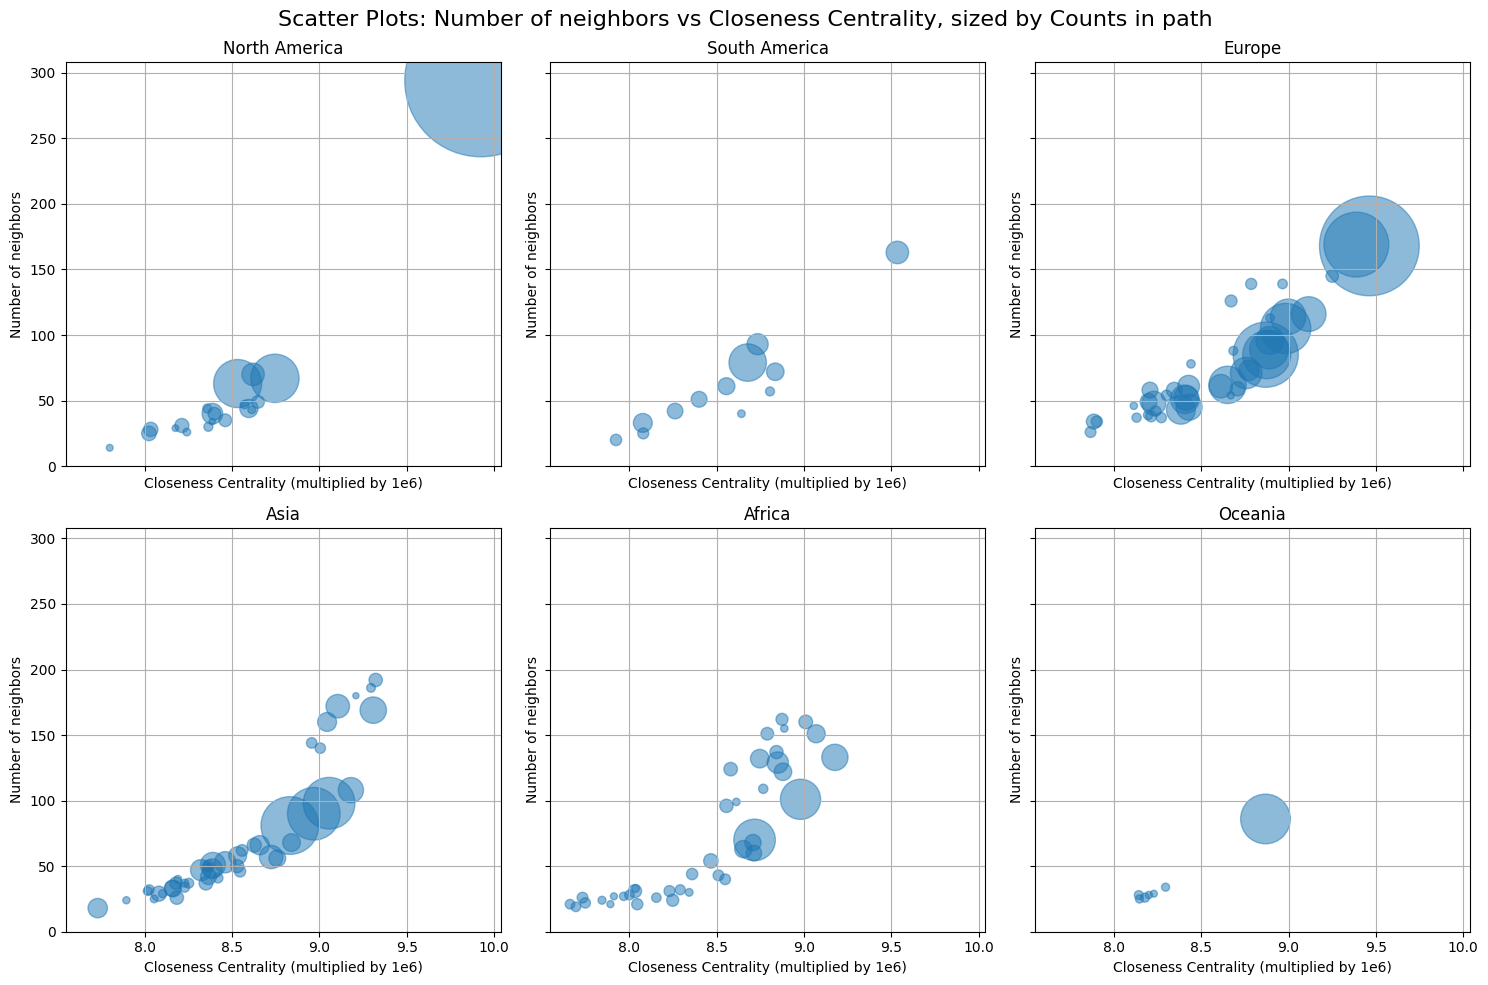

In [138]:
plt.figure(figsize=(15, 10))

continents = df_comp['Continent'].unique()

fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)

for i, continent in enumerate(continents):
    df_cont = df_comp[df_comp['Continent'] == continent]
    axs[i//3, i%3].scatter(df_cont['Closeness Centrality'], df_cont['Number of Connexions'],alpha=0.5, s=df_cont['Count_in_paths'])
    axs[i//3, i%3].set_xlabel('Closeness Centrality (multiplied by 1e6)')
    axs[i//3, i%3].set_ylabel('Number of neighbors')
    axs[i//3, i%3].set_title(continent)
    axs[i//3, i%3].grid(True)

plt.suptitle('Scatter Plots: Number of neighbors vs Closeness Centrality, sized by Counts in path', fontsize=16)
plt.tight_layout()
plt.show()

Not that much to see directly, but it nice to recognize on here Argentina, on the South American plot, so far to the top right. Notice however, that the Asia plot shows that the most used countries do not correspond to either the most central nor the ones with the most neighbors, let's give that a second look!

In [139]:
df_asia = df_comp[df_comp.Continent == "Asia"].sort_values(by=['Count_in_paths'], ascending=False)
display(df_asia.head(10))


,ISO,Country,Count,Average Success Rate,Average Excess Path Length,Population,GDP,Normalized Population,Normalized GDP,GDP per capita,Continent,Count_in_paths,Success_when_used,Article,Closeness Centrality,Number of Connexions
37,IND,india,31,0.750000,3.0,1.257621e+09,1.823052e+12,8.181268,0.893356,1449.603301,Asia,1731,0.702484,india,8.830802,81
1,CHN,china,118,1.000000,5.0,1.345035e+09,7.551546e+12,8.769585,4.632503,5614.386022,Asia,1437,0.772443,china,8.967806,90
3,JPN,japan,91,0.937500,4.0,1.278330e+08,6.233147e+12,0.577511,3.771947,48760.078949,Asia,1386,0.772006,japan,9.055510,98
40,ISR,israel,30,0.416667,3.0,7.765800e+06,2.667919e+11,-0.230572,-0.122459,34354.716118,Asia,362,0.803867,israel,9.308387,169
54,IRN,iran,26,0.666667,2.0,7.634297e+07,6.261331e+11,0.230970,0.112093,8201.581678,Asia,330,0.800000,iran,9.180207,108
15,IRQ,iraq,44,1.000000,12.0,3.237806e+07,1.857497e+11,-0.064925,-0.175357,5736.898959,Asia,323,0.789474,iraq,8.389966,51
65,TUR,turkey,22,0.625000,3.0,7.422363e+07,8.387853e+11,0.216706,0.250897,11300.785222,Asia,288,0.746528,turkey,9.104980,172
39,IDN,indonesia,30,1.000000,1.0,2.470997e+08,8.929691e+11,1.380206,0.286265,3613.800888,Asia,284,0.764085,indonesia,8.723720,57
2,VNM,vietnam,109,0.916667,1.0,8.834912e+07,1.725950e+11,0.311774,-0.183943,1953.557150,Asia,236,0.805085,vietnam,8.460237,53
58,PAK,pakistan,25,0.666667,4.0,1.986027e+08,2.305866e+11,1.053809,-0.146091,1161.044321,Asia,231,0.744589,pakistan,8.322237,47


The outliers here are Turkey and Israel, which, again, may be missed due to more cultural associations with the "Asian Giants" of India, China and Japan, each used in paths over a thousand times more, despite both worse centrality and a *considerably* worse number of connexions!

,Count_in_paths,Closeness Centrality
Continent,,
Africa,125.750000,8.688544
Asia,217.244444,8.761352
Europe,483.536585,8.997882
North America,794.900000,9.587613
Oceania,212.285714,8.774176
South America,181.166667,8.659898


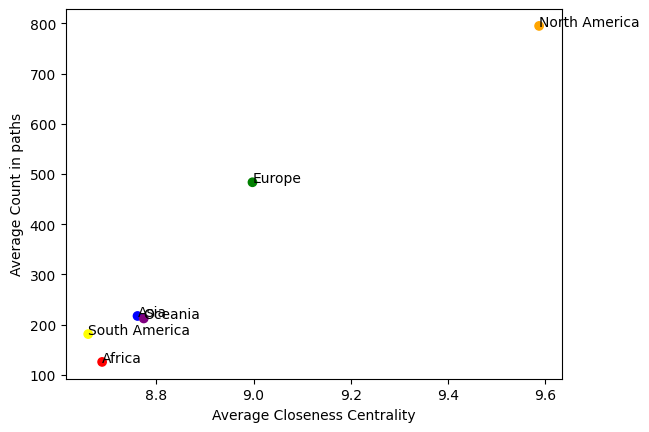

In [140]:
df_agg_continents = df_comp[['Continent','Count_in_paths', 'Closeness Centrality', 'Number of Connexions']].groupby('Continent').agg({
            'Count_in_paths': 'mean', 
            'Closeness Centrality': lambda x: np.average(x, weights=df_comp.loc[x.index, 'Count_in_paths']), 
            #'Number of Connexions': lambda x: np.average(x, weights=df_comp.loc[x.index, 'Count_in_paths'])
            })

display(df_agg_continents)


colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow']

plt.scatter(df_agg_continents['Closeness Centrality'], df_agg_continents['Count_in_paths'], c= colors)

for i, continent in enumerate(df_agg_continents.index):
    plt.text(df_agg_continents.loc[continent, 'Closeness Centrality'], df_agg_continents.loc[continent, 'Count_in_paths'], continent)
plt.xlabel('Average Closeness Centrality')
plt.ylabel('Average Count in paths')
plt.show()


It would seem the more central Africa is less utilized than South America! But, what about looking at North America without the United States, do players give the same importance to Panama and Belize?

,Count_in_paths,Closeness Centrality
Continent,,
Africa,125.750000,8.688544
Asia,217.244444,8.761352
Europe,483.536585,8.997882
North America,204.789474,8.547806
Oceania,212.285714,8.774176
South America,181.166667,8.659898


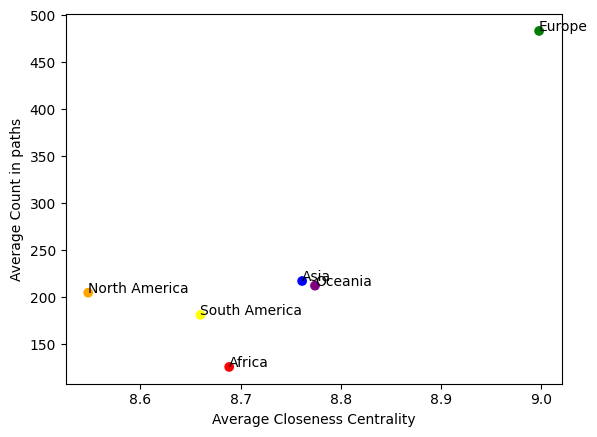

In [141]:
df_comp2 = df_comp[df_comp.ISO != "USA"].copy()
df_agg_continents2 = df_comp2[['Continent','Count_in_paths', 'Closeness Centrality', 'Number of Connexions']].groupby('Continent').agg({
            'Count_in_paths': 'mean', 
            'Closeness Centrality': lambda x: np.average(x, weights=df_comp2.loc[x.index, 'Count_in_paths']), 
            #'Number of Connexions': lambda x: np.average(x, weights=df_comp.loc[x.index, 'Count_in_paths'])
            })

display(df_agg_continents2)


colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow']

plt.scatter(df_agg_continents2['Closeness Centrality'], df_agg_continents2['Count_in_paths'], c= colors)

for i, continent in enumerate(df_agg_continents2.index):
    plt.text(df_agg_continents2.loc[continent, 'Closeness Centrality'], df_agg_continents2.loc[continent, 'Count_in_paths'], continent)
plt.xlabel('Average Closeness Centrality')
plt.ylabel('Average Count in paths')
plt.show()


Without the United States as the hyper-connected article, North American country articles are much less central to the Wikispeedia network, and we can see here that we still have a bias of overusing those articles, despite them being the worse in Closeness Centrality, in fact, they are closer in use to Asia in Oceania, which are more central!

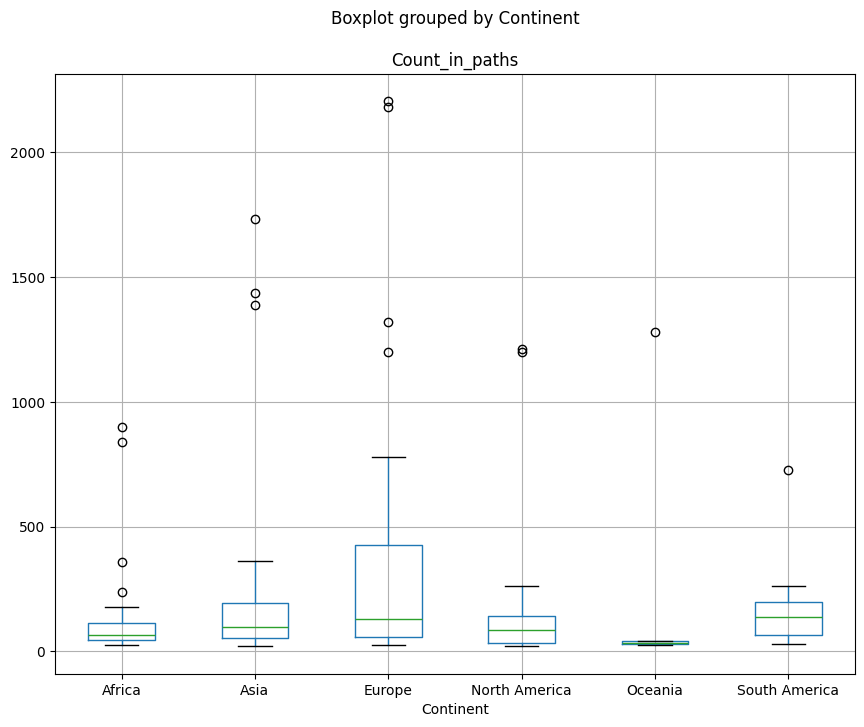

In [142]:
df_comp2[df_comp2['Count_in_paths'] < 5000].boxplot(column=['Count_in_paths'], by='Continent', figsize=(10, 8))

Here's a boxplot of the uses of articles according to continent, with the US and UK being taken out due to them being such large outliers!

Let's now try to quantify what makes a country visible culturally! Let's finally use our metrics of GDP and population, and maybe try to look at other metrics like sports performances!

In [143]:
olympic_medals_path = '../added_data/olympic_medals_by_country.csv'

df_olympic_medals = pd.read_csv(olympic_medals_path, comment='#', sep=',')

selected_columns = ['cca3', 'olympicMedalsByCountry_totAll', 'olympicMedalsByCountry_totGold', 'olympicMedalsByCountry_totSilv', 'olympicMedalsByCountry_totBrz']
df_olympic_medals = df_olympic_medals[selected_columns].copy()
df_olympic_medals = df_olympic_medals.fillna(0)

df_olympic_medals = df_olympic_medals.rename(columns={'cca3': 'ISO', 'olympicMedalsByCountry_totAll': 'Total Medals', 'olympicMedalsByCountry_totGold': 'Gold Medals',
                                                       'olympicMedalsByCountry_totSilv': 'Silver Medals', 'olympicMedalsByCountry_totBrz': 'Bronze Medals'})


df_sport = pd.merge(df_comp, df_olympic_medals, on='ISO', how='left')

display(df_sport)

,ISO,Country,Count,Average Success Rate,Average Excess Path Length,Population,GDP,Normalized Population,Normalized GDP,GDP per capita,Continent,Count_in_paths,Success_when_used,Article,Closeness Centrality,Number of Connexions,Total Medals,Gold Medals,Silver Medals,Bronze Medals
0,USA,united_states,29,0.947368,1.000000,311583481.0,1.559973e+13,1.814198,9.885775,50065.966504,North America,12007,0.722495,united_states,9.924573,294,2980.0,1180.0,959.0,841.0
1,ARG,argentina,31,0.857143,13.000000,41261490.0,5.301581e+11,-0.005137,0.049448,12848.739151,South America,263,0.813688,argentina,9.534706,163,77.0,21.0,26.0,30.0
2,GBR,united_kingdom,28,0.947368,1.000000,63258810.0,2.663806e+12,0.142910,1.442139,42109.641880,Europe,5160,0.737791,united_kingdom,9.462528,168,948.0,296.0,320.0,332.0
3,DEU,germany,55,0.555556,2.000000,80274983.0,3.749315e+12,0.257433,2.150681,46705.895796,Europe,2182,0.796517,germany,9.387908,169,892.0,293.0,293.0,306.0
4,LBN,lebanon,17,0.885714,5.000000,5045056.0,3.992713e+10,-0.248883,-0.270539,7914.109568,Asia,93,0.741935,lebanon,9.322271,192,4.0,0.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,SEN,senegal,21,0.800000,1.000000,12875880.0,1.781428e+10,-0.196179,-0.284973,1383.539116,Africa,56,0.750000,senegal,7.747134,22,1.0,0.0,1.0,0.0
161,MLI,mali,12,0.928571,2.000000,16039734.0,1.299511e+10,-0.174886,-0.288119,810.182556,Africa,60,0.816667,mali,7.731560,26,NaN,NaN,NaN,NaN
162,ARE,united_arab_emirates,126,0.861949,2.301587,8575205.0,3.608327e+11,-0.225124,-0.061075,42078.613813,Asia,195,0.835897,united_arab_emirates,7.730365,18,2.0,1.0,0.0,1.0
163,GAB,gabon,14,0.933333,2.000000,1772500.0,1.821031e+10,-0.270908,-0.284715,10273.798445,Africa,48,0.875000,gabon,7.693491,19,1.0,0.0,1.0,0.0


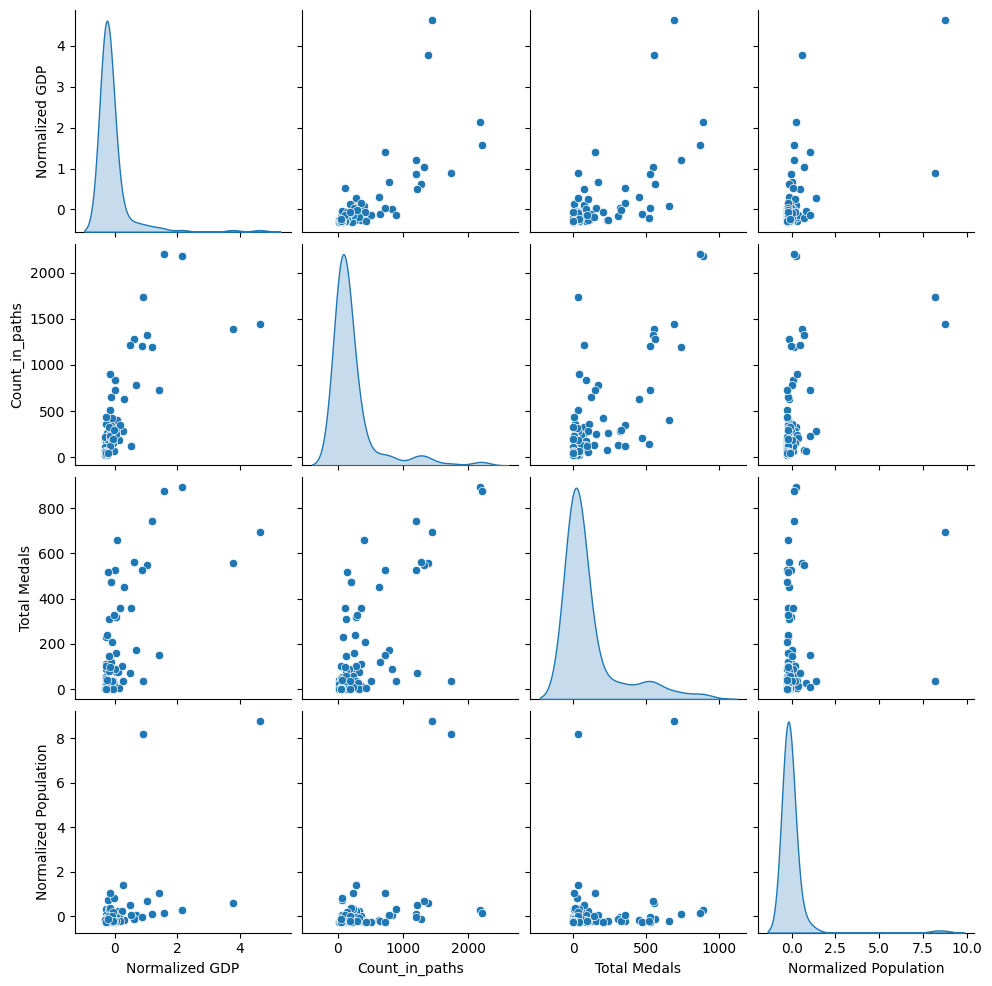

In [144]:
df_pairplottable = df_sport[['Normalized GDP', 'Count_in_paths', 'Total Medals', 'Normalized Population']].copy()
df_pairplottable = df_pairplottable[df_pairplottable['Count_in_paths'] < 5000].copy()
sns.pairplot(df_pairplottable, diag_kind='kde')

A log transform seems to be in order here!

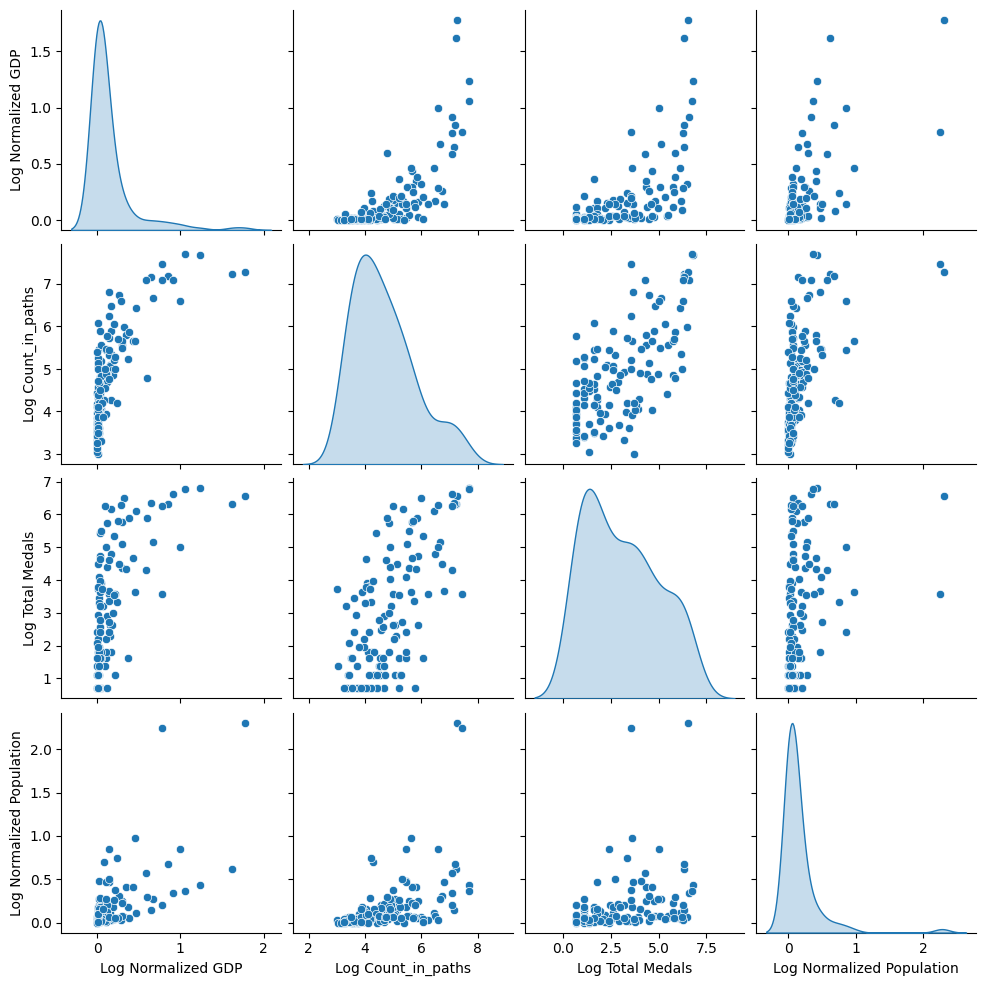

In [145]:
df_pairplottable_log = df_pairplottable.copy()
df_pairplottable_log['Count_in_paths'] = np.log(df_pairplottable_log['Count_in_paths'])
df_pairplottable_log['Normalized GDP'] = np.log(df_pairplottable_log['Normalized GDP'] - df_pairplottable_log['Normalized GDP'].min() + 1 )
df_pairplottable_log['Total Medals'] = np.log(df_pairplottable_log['Total Medals']+ 1 )
df_pairplottable_log['Normalized Population'] = np.log(df_pairplottable_log['Normalized Population'] - df_pairplottable_log['Normalized Population'].min() + 1 )
df_pairplottable_log.rename(columns={'Normalized GDP': 'Log Normalized GDP', 'Count_in_paths': 'Log Count_in_paths',
                                      'Total Medals' : 'Log Total Medals', 'Normalized Population' : 'Log Normalized Population'}, inplace=True)

sns.pairplot(df_pairplottable_log, diag_kind='kde')

Pay attention to the second line, we're looking at the Counts in path in relation to other variables!

Note also that the USA has been taken out, it is such an outlier in all three categories it hurts the readability of the graphs!

It certainly looks like countries with a better GDP are overperformers when it comes to being chosen in a path, and we have something that looks pretty promising when it comes to Counts in path and Medals awarded, with an issue being that it looks like there is some relation between the medals and GDP too...

Note that despite our best attempts at normalization, distributions of poplation and GDP remain *very* heavy-tailed. 

Time to verify for each value!

In [146]:
df_fixed = df_sport.copy()
df_fixed['Normalized_GDP_log'] = np.log(df_fixed['Normalized GDP'] - min(df_fixed['Normalized GDP']) + 1)   #Minimum value is 0, so we add 1 to avoid log(0), we get log(1) at 0
df_fixed['Population_log'] = np.log(df_fixed['Population'])
df_fixed['Total_Medals_log'] = np.log(df_fixed['Total Medals'])
df_fixed['Counts_log'] = np.log(df_fixed['Count_in_paths'])

model_fixed = smf.ols(formula='Counts_log ~ Normalized_GDP_log + Population_log + Total_Medals_log', data=df_fixed).fit()
model_fixed.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Counts_log   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     96.06
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           1.57e-31
Time:                        17:26:29   Log-Likelihood:                -123.35
No. Observations:                 122   AIC:                             254.7
Df Residuals:                     118   BIC:                             265.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.6615      0.619      2.684      0.008       0.435       2.888
Normalized_GDP_log     1.5819      0.226      6.985      0.000       1.133       2.030
Population_log         0.1591      0.040      3.948      0.000       0.079       0.239
Total_Medals_log       0.1461      0.038      3.867      0.000       0.071       0.221
==============================================================================
Omnibus:                        2.363   Durbin-Watson:                   1.689
Prob(Omnibus):                  0.307   Jarque-Bera (JB):                1.839
Skew:                           0.210   Prob(JB):                        0.399
Kurtosis:                       3.431   Cond. No.                         170.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

                           0         1
Intercept           0.435464  2.887579
Normalized_GDP_log  1.133385  2.030324
Population_log      0.079303  0.238939
Total_Medals_log    0.071294  0.220973


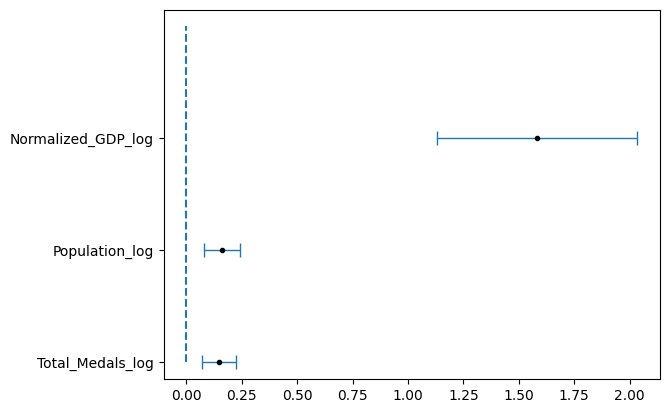

In [147]:
variables2 = model_fixed.params.index

coeffs2 = model_fixed.params.values
p_values2 = model_fixed.pvalues.values
standard_errors2 = model_fixed.bse.values

conf_ints2 = model_fixed.conf_int()

print(conf_ints2)

l1, l2, l3, l4 = zip(*sorted(zip(coeffs2[1:], variables2[1:], standard_errors2[1:], p_values2[1:])))

plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

plt.vlines(0,0, len(l1), linestyle = '--')

plt.yticks(range(len(l2)),l2)
plt.show()

With small p-values, these relations are not due to random chance, and with an Rsquare of 0.7, this indicates a strong correlation! It does look however like GDP is a dominating factor, so let's actually go ahead and check for cross-relations, with a fuller set of regressions!

In [148]:
model_filled = smf.ols(formula='Counts_log ~ Normalized_GDP_log + Population_log + Total_Medals_log +\
                                Normalized_GDP_log * Population_log + Normalized_GDP_log * Total_Medals_log +\
                                Population_log * Total_Medals_log', data=df_fixed).fit()
model_filled.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Counts_log   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     56.53
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           4.90e-32
Time:                        17:26:29   Log-Likelihood:                -114.96
No. Observations:                 122   AIC:                             243.9
Df Residuals:                     115   BIC:                             263.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               1.8296      0.919      1.991      0.049       0.009       3.650
Normalized_GDP_log                     11.9240      2.560      4.657      0.000       6.852      16.996
Population_log                          0.1473      0.061      2.435      0.016       0.027       0.267
Total_Medals_log                       -0.0926      0.420     -0.220      0.826      -0.925       0.740
Normalized_GDP_log:Population_log      -0.4915      0.137     -3.584      0.000      -0.763      -0.220
Normalized_GDP_log:Total_Medals_log    -0.1200      0.128     -0.936      0.351      -0.374       0.134
Population_log:Total_Medals_log         0.0111      0.026      0.423      0.673      -0.041       0.063
==============================================================================
Omnibus:                        7.070   Durbin-Watson:                   1.750
Prob(Omnibus):                  0.029   Jarque-Bera (JB):                8.443
Skew:                           0.344   Prob(JB):                       0.0147
Kurtosis:                       4.090   Cond. No.                     2.88e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.88e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Oh well, it looks like there is no real relation with sports performance, that relation had been rather a more direct relation with population and GDP, and this makes sense! The economic strength of a nation is a decisive factor in its place in our minds (let's rather leave that point to the philosophers...), so we're more likely to seek those nations out! A nation's economic status might also mean it perhaps had a strong role in history and in modern technology and science. As for population, it's also quite intuitive that large population countries would be seeked out, for their perceived importance!